<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/Canny_Skeleton_Code_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

--2021-03-13 15:57:29--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.02s   

2021-03-13 15:57:29 (6.35 MB/s) - ‘lena.jpg’ saved [105764/105764]



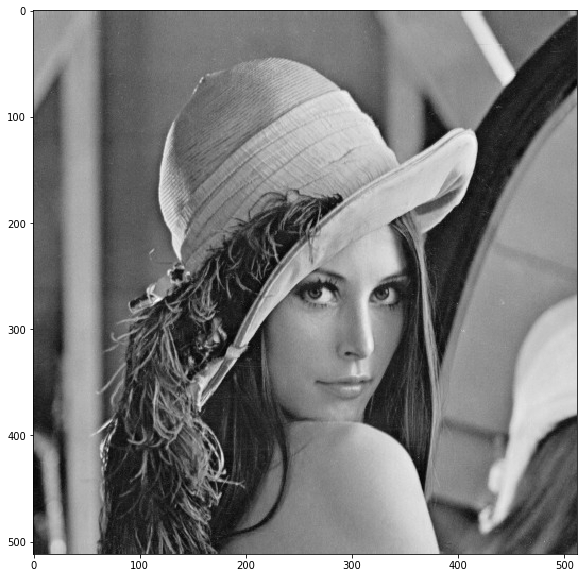

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = 'lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

## Step 1:
a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [65]:
def compute_gradient(img,sigma,threshold=0):
    '''
    Inputs: input image, sigma and threshold parameter
    Outputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    '''
    # insert your code here
    Gx=ndimage.gaussian_filter(img, sigma, (0,1))
    Gy=ndimage.gaussian_filter(img, sigma, (1,0))
    g_norm = np.sqrt(Gx**2+Gy**2)
    g_norm = g_norm / g_norm.max()*255
    g_norm = (g_norm>=threshold) * g_norm

    g_theta = np.arctan2(Gy,Gx)


    return g_norm, g_theta



In [43]:
g_norm, g_theta = compute_gradient(img,1,0)

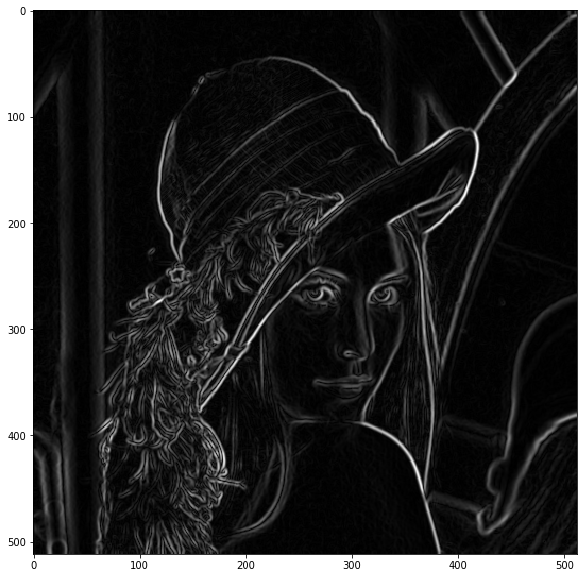

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(g_norm)

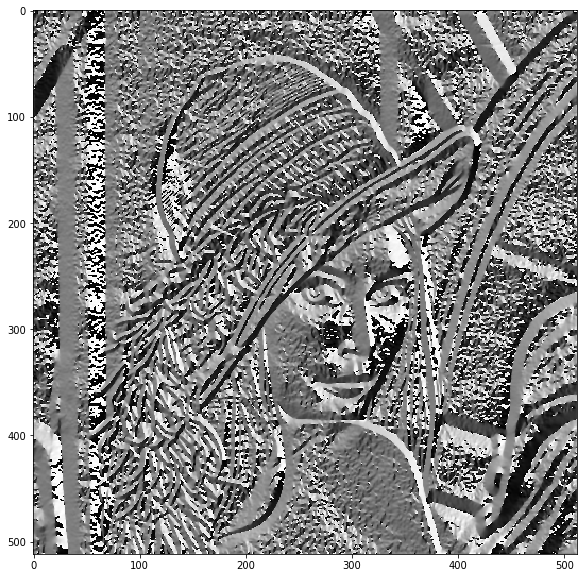

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(g_theta)

## Step 2:
b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary images with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [15]:
def non_max_suppression(g_norm, g_theta):
    '''
    Inputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    Outputs: I - image processed with non-max supression
    '''
    # insert your code here
    M, N = g_norm.shape
    Z = np.zeros((M,N),dtype=np.int32)
    angle = g_theta * 180./np.pi
    angle[angle<0] +=180

    q = 255
    r = 255
    # map to 0
    for i in range (1, M-1):
      for j in range(1, N-1):
        if (0<=angle[i,j]<22.5) or (157.5<=angle[i,j]<=180):
          q = g_norm[i, j+1]
          r = g_norm[i, j-1]
        # map to 45
        elif 22.5<=angle[i,j]<67.5:
          q = g_norm[i-1, j+1]
          r = g_norm[i+1, j-1]
        elif 67.5<=angle[i,j]<112.5:
          q = g_norm[i+1,j]
          r = g_norm[i-1,j]
        else:
          q = g_norm[i+1,j+1]
          r = g_norm[i-1,j-1]
        
        if g_norm[i,j]>q and g_norm[i,j]>r:
          Z[i,j] = g_norm[i,j]
        else:
          Z[i,j] = 0

    return Z



In [46]:
Z = non_max_suppression(g_norm, g_theta)

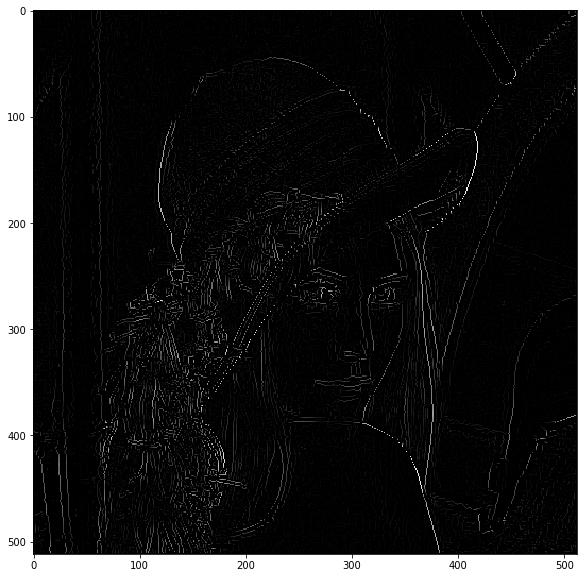

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(Z)

## Step 3:
c- Combine 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

In [24]:
def threshold(img,highThreshold,lowThreshold):
    '''
    Inputs: img - image processes with non-max supression, 
            highThreshold,lowThreshold - high and low threshodl ratios
    Outputs: res - output image, weak, strong - pixel values assiged to weak and strong images
    '''
    # insert your code here
    highThreshold = img.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    M, N = img.shape
    res = np.zeros((M,N),dtype=np.int32)

    weak = 100
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak 
    

    return (res, weak, strong)



In [58]:
(res, weak, strong) = threshold(Z,0.2,0.3)

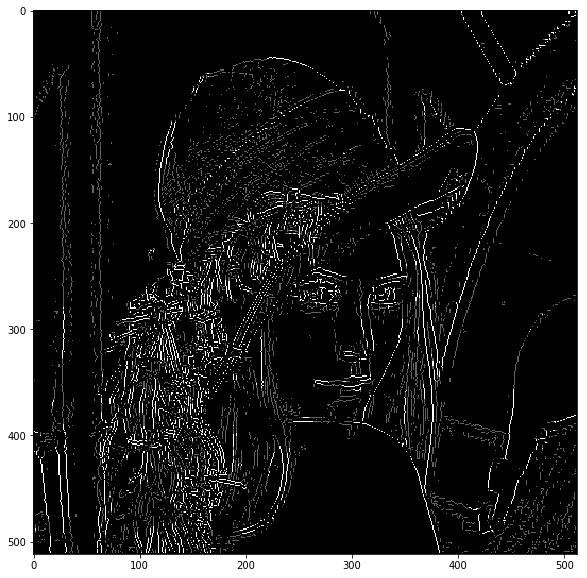

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(res)

## Step 4:
d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step c with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [67]:
def hysteresis(img, weak, strong):
    '''
    Inputs: res - thresholded NMS image, 
    weak, strong - pixel values assiged to weak and strong images
    
    Outputs: img - result after hysteresis
    '''

    # insert your code here
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
              if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                  or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                  or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                  img[i, j] = strong
              else:
                  img[i, j] = 0
    
    
    return img



In [60]:
fin = hysteresis(res,weak,strong)

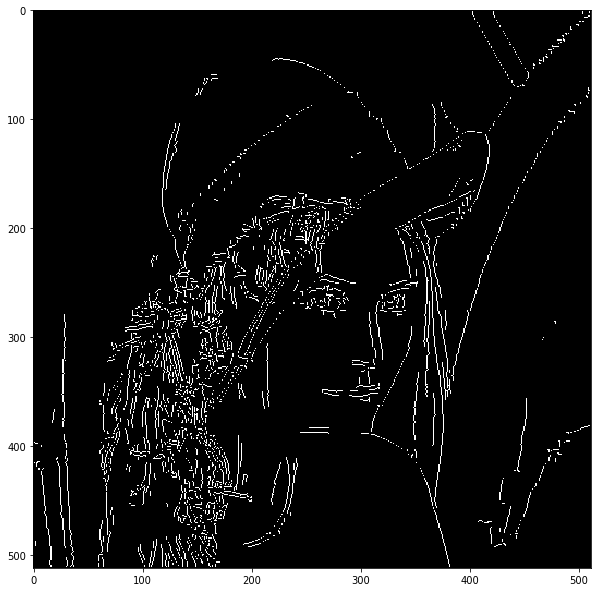

In [63]:
plt.figure(figsize=(10,20))
plt.imshow(fin)

## Step 5:
e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

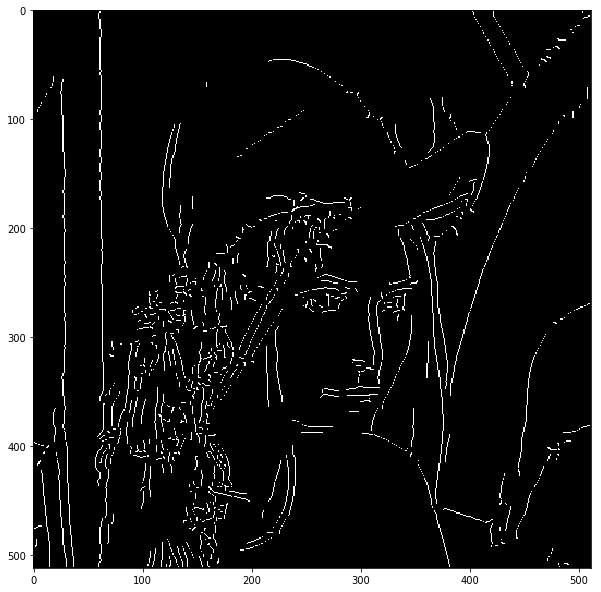

In [66]:
# parameters to check
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255


'''
gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)
'''
gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)